In [2]:
import junodch_utils_read_img as utils

import matplotlib.pyplot as matPlt
import numpy as np
from sklearn.svm import OneClassSVM
from sklearn.metrics import confusion_matrix

import rasterio
import keras
from keras import layers
from rasterio import plot as rastPlt

# Data preparation
### Fetch data from file

In [3]:
def formatDataForSVM(data, res=32, toFloat=True):
  # fix inconcistant shapes
  newData = []
  for i, d in enumerate(data):
    npdata = np.copy(d)
    if npdata.shape[1] < res or npdata.shape[2] < res:
      pad1 = res - npdata.shape[1]
      pad2 = res - npdata.shape[2]
      npdata = np.lib.pad(npdata, ((0,0),(0,pad1 if pad1 > 0 else 0),(0,pad2 if pad2 > 0 else 0)), 'constant', constant_values=(0))
    if npdata.shape[1] > res or npdata.shape[2] > res:
      npdata=npdata[:,0:res,0:res]
    newData.append(npdata.flatten())

  # to numpy
  newData = np.asarray(newData)
  if toFloat:
    newData = newData.astype("float32") / 255.0
  
  return newData

def displayResultSVM(svm, dataInput, res=64):
  MAX_ON_ROW = 20
  total = len(dataInput)
  nRow = (total // MAX_ON_ROW) + 1
  nCol = MAX_ON_ROW if total > MAX_ON_ROW else total

  score = svm.predict(formatDataForSVM(dataInput,res=res, toFloat=True))
  imgs = utils.formatData(dataInput, res=res, toFloat=True)
  matPlt.figure(figsize=(30,nRow*2))
  for i in range(0, total):
    ax = matPlt.subplot(nRow, nCol, 1+i)
    matPlt.title('T' if score[i] == 1 else 'F')
    matPlt.imshow(imgs[i])
    ax.get_xaxis().set_visible(False)
    ax.get_yaxis().set_visible(False)
  matPlt.show()


In [4]:
folderName = "img/Sokoto/"
pathSatellite = folderName + "Sentinel-2.tif"
#pathNight = folderName + "Night VIIRS_1.tif"
pathNight = folderName + "lowres_night_1.tif"
pathValidation = folderName + "Population GHSL_1.tif"

aoi = utils.getImgBorder(pathSatellite)

# Fetch coords
dataCoords, dataRadiance = utils.getTilesCoordsPerimeter(pathNight, validThreshold=1, area=aoi)

trainMask = dataRadiance>25
lightCoords = dataCoords[trainMask]

print('Tiles:',dataCoords.shape[0])
print('Light Tile:',lightCoords.shape[0])


Tiles: 137868
Light Tile: 894


In [5]:
# Fetch images
with rasterio.open(pathSatellite) as f:
  trainData, _ = utils.getEachImgFromCoord(f, dataCoords[trainMask], True)
trainData = utils.formatData(trainData, res=64, toFloat=True)

## svm

In [6]:
autoencoder = keras.models.load_model('model/autoencoder_64x64_encoder_1024')
#autoencoder = keras.models.load_model('model/autoencoder_32x32_encoder_256')
encoder = keras.Model(inputs=autoencoder.inputs, outputs=autoencoder.get_layer('encoder').output)

In [7]:
testCoordsData = dataCoords[::100]
#testCoordsData = dataCoords

print('Process validation...')
getValid = lambda data : [ int(any([ any(c > 250 for c in row) for row in img[0] ])) for img in data ]
resultValid = utils.scanSatellite(pathValidation, testCoordsData, getValid, batch=1000)

Process validation...


In [9]:
svm = OneClassSVM(gamma='scale', kernel='rbf', nu=0.8, tol=1e-3)
svm = svm.fit(encoder.predict(trainData), sample_weight=dataRadiance[trainMask])

getScore = lambda data : [1 if i == 1 else 0 for i in svm.predict(encoder.predict(utils.formatData(data, res=64, toFloat=True), verbose=0))]

print('Process score...')
result = utils.scanSatellite(pathSatellite, testCoordsData, getScore, batch=1000)

print('Process confustion matrix...')
print('total:',len(result))
cm = confusion_matrix(resultValid, result)
print(cm)
print('accuracy:',np.round((cm[1][1])/(cm[0][1]+cm[1][1])*100,2),'%')

28/28 [==============================] - 1s 16ms/step
Process score...
Process confustion matrix...
total: 1379
[[1038  110]
 [ 200   31]]
accuracy: 21.99 %


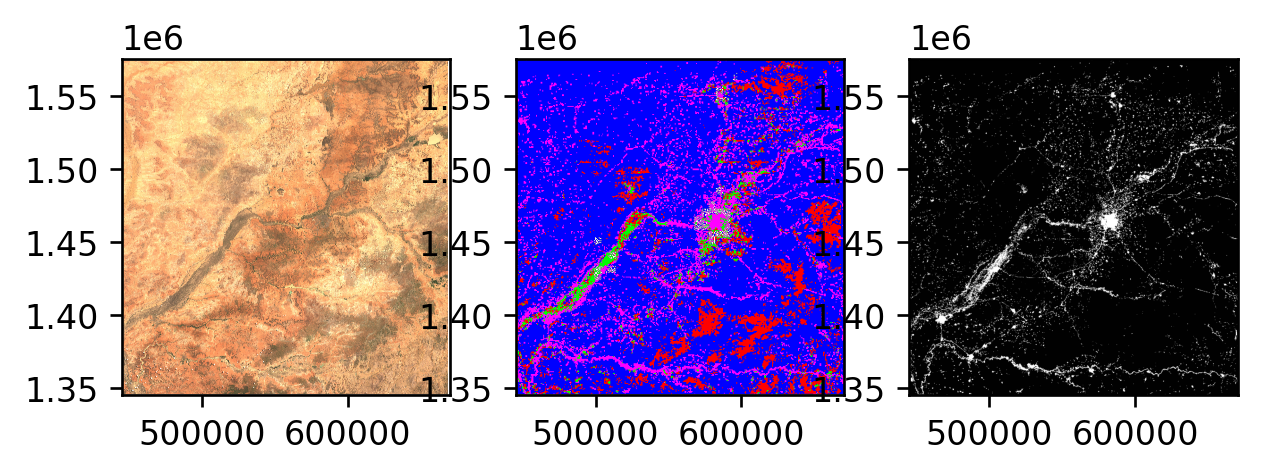

In [113]:
resultImg, resultMeta = utils.mapResultOnImg(pathNight, testCoordsData, result, resultValid)

fig, axs = matPlt.subplots(1,3, dpi=240)
with rasterio.open(pathSatellite) as s: utils.displayTiles([s.read()], [s.transform],axs[0])

axs[2].set_xlim(axs[0].get_xlim())
axs[2].set_ylim(axs[0].get_ylim())

with rasterio.open(pathValidation) as p: rastPlt.show(p, ax=axs[2])

axs[1].set_xlim(axs[0].get_xlim())
axs[1].set_ylim(axs[0].get_ylim())

utils.displayTiles([resultImg], [resultMeta], axs[1])

## Test

In [ ]:
#indexesTest = [*np.argwhere(trainMask)[-20:].flatten(), *range(0,1), *range(1104,1108), *range(1118,1123), *range(4005,4010), *range(10005,10010)]
indexesTest = [*np.argwhere(trainMask)[-20:].flatten(), *range(0,1), *range(1104,1108), *range(1118,1123)]

with rasterio.open(pathSatellite) as f:
  dataTest, _ = utils.getEachImgFromCoord(f, dataCoords[indexesTest], True)

displayResultSVM(svm, dataTest)